In [ ]:
library(ggplot2)
library(dplyr)
library(LDlinkR)

In [8]:
############### old results (Cuomo*, Seaton*, McCarthy* et al Nat Comm 2020)

In [9]:
# load lead variant results sc stages (iPS, mesendo, defendo)
leads.ips = read.csv("/nfs/leia/research/stegle/acuomo/mean/day0/all_expts/leads.csv", row.names = 1)
leads.mes = read.csv("/nfs/leia/research/stegle/acuomo/mean/mesendo_est_June20/leads.csv", row.names = 1)
leads.defendo = read.csv("/nfs/leia/research/stegle/acuomo/mean/defendo_est_June20/leads.csv", row.names = 1)

In [10]:
# add differentiation stage information
leads.ips$stage = "ips"
leads.mes$stage = "mesendo"
leads.defendo$stage = "defendo"

In [11]:
# merge results
endo_eqtl = rbind(leads.ips, 
                 leads.mes,
                 leads.defendo)

In [12]:
# pick top SNP across stages (min p_value)

In [13]:
# order by p_value
endo_eqtl = endo_eqtl[order(endo_eqtl$p_value),]
nrow(endo_eqtl)
head(endo_eqtl,2)

[1] 32665

,beta,beta_se,empirical_feature_p_value,p_value,snp_id,feature,global_corr_p_value,chrom,pos,ref_allele,...,permutation_1,permutation_2,permutation_3,permutation_4,permutation_5,permutation_6,permutation_7,permutation_8,permutation_9,stage
6,-1.457854,0.1020245,9.536615e-26,2.553619e-46,4_39446549_G_A,ENSG00000163682_RPL9,1.260613e-22,4,39446549,G,...,0.02499141,0.6516389,0.4681722,0.3833344,0.05690061,0.02657527,0.2945979,0.02514148,0.7088325,ips
12,1.801311,0.1333499,3.391301e-21,1.399851e-41,7_55806087_G_T,ENSG00000226278_PSPHP1,2.241423e-18,7,55806087,G,...,0.10854778,0.0611202,0.3728356,0.2267340,0.60751447,0.24224812,0.6809891,0.47102673,0.2149549,ips


In [14]:
# select only one SNP per gene 
endo_eqtl = endo_eqtl[-which(duplicated(endo_eqtl$feature)),]
nrow(endo_eqtl)

[1] 10788

In [15]:
T = 0.1
## consider significant hits only (FDR<10%)
endo_eqtl = endo_eqtl[endo_eqtl$global_corr_p_value <= T,]

In [16]:
nrow(endo_eqtl)

[1] 3079

In [17]:
endo_eqtl$feature_id = gsub("_.*","",endo_eqtl$feature)

In [18]:
# CellRegMap association test

In [19]:
revision_folder = "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/"

In [20]:
crm_file = paste0(revision_folder, "CRM_association/summary.csv")
crm = read.csv(crm_file, row.names=1)
colnames(crm) = c("feature_id", "n_snps", "feature_chromosome","p_value","snp_id","p_value_Bonferroni") 
nrow(crm)
head(crm,2)

[1] 10003258

,feature_id,n_snps,feature_chromosome,p_value,snp_id,p_value_Bonferroni
0,ENSG00000250462,909,17,0.5215900,17_28857239_G_A,1
1,ENSG00000250462,909,17,0.6535075,17_28857794_C_T,1


In [27]:
length(unique(crm$feature_id))

[1] 10493

In [21]:
res = crm

In [23]:
cols = c("feature_id","snp_id")
df = inner_join(endo_eqtl[,c("stage",cols)], res[,cols], by = c("feature_id"), suffix=c(".old",".new"))

In [26]:
nrow(df)
length(unique(df$feature_id))

[1] 2930687

[1] 2996

In [28]:
# collect all SNPs
all_snps = unique(c(as.character(df$snp_id.old), as.character(df$snp_id.new)))
length(all_snps)
head(all_snps)

[1] 2193664

[1] "4_39446549_G_A" "7_55806087_G_T" "6_31486901_T_C" "17_7151111_A_C"
[5] "6_32597313_T_C" "6_31132414_G_A"

In [29]:
snp_df = data.frame(snp=all_snps)
head(snp_df,2)

snp
4_39446549_G_A
7_55806087_G_T


In [30]:
nrow(snp_df)

[1] 2193664

In [31]:
# re-format SNPs
# from 19_2908680_T_C to chr19:2908680

In [ ]:
S1 = unlist(strsplit(as.character(df$snp_id.old),"_"))
chrs = c()
snps = c()
for (i in seq(1,(length(S1)-1),4)){
   chrs = c(chrs,S1[i]) 
}
for (i in seq(2,(length(S1)-1),4)){
   snps = c(snps,S1[i]) 
}
df$snp1 = paste0("chr",chrs,":",snps)

In [ ]:
S2 = unlist(strsplit(as.character(df$snp_id.new),"_"))
chrs = c()
snps = c()
for (i in seq(1,(length(S2)-1),4)){
   chrs = c(chrs,S2[i]) 
}
for (i in seq(2,(length(S2)-1),4)){
   snps = c(snps,S2[i]) 
}
df$snp2 = paste0("chr",chrs,":",snps)

In [ ]:
nrow(df)

In [ ]:
df$d = NA
for (i in 1:nrow(df)){
    print(i)
    snp1 = as.character(df[i,"snp1"])
    snp2 = as.character(df[i,"snp2"])
#     print(snp1)
#     print(snp2)
    try({df[i,"d"] = as.numeric(LDpair(snp1, snp2, pop = "GBR", token = "f88ab64286ce")$d_prime)})
}

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 4)
p = ggplot(df, aes(x=d)) + geom_histogram(alpha = 0.8) + 
    xlab("D' LD value") + ylab("Number of SNPs") + theme_classic()
p

In [ ]:
fig_dir = "/hps/nobackup2/stegle/users/acuomo/CellRegMap_data/figures/"
pdf(paste0(fig_dir,"SF4_LD_hist.pdf"), width=7, height=4)
p
dev.off()

In [1]:
revision_folder = "/hps/nobackup2/stegle/users/acuomo/all_scripts/struct_LMM2/sc_endodiff/debug_May2021/REVISION/"

In [2]:
df = read.csv(paste0(revision_folder, "CRM_association_comparison_LD_values.csv"))

In [7]:
nrow(df)

[1] 984

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 108 rows containing non-finite values (stat_bin).”

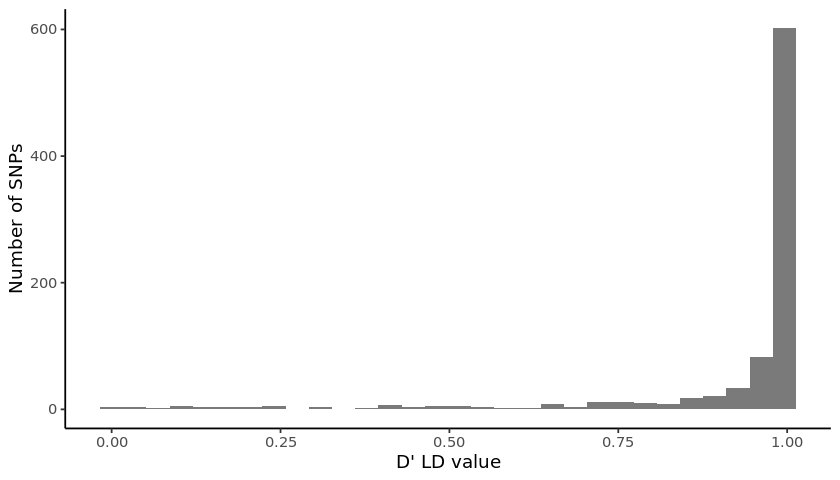

In [6]:
options(repr.plot.width = 7, repr.plot.height = 4)
p = ggplot(df, aes(x=d)) + geom_histogram(alpha = 0.8) + 
    xlab("D' LD value") + ylab("Number of SNPs") + theme_classic()
p